<a href="https://colab.research.google.com/github/ayanoglu/REDGPA/blob/GPR/REDGPAmain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout
from numpy import array
from sklearn import preprocessing
from sklearn.utils import shuffle
import pandas as pd
import numpy as np
np.set_printoptions(linewidth=160)
import tensorflow as tf
import csv
import math
import matplotlib.pyplot as plt
from decimal import *
from google.colab import files
import plotly.graph_objects as go
import plotly.express as px
import itertools
from itertools import combinations
import time
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import io

from sklearn.metrics import r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel

uploaded = files.upload()

Saving Survey_numerical_score_GPA.csv to Survey_numerical_score_GPA.csv


In [2]:
DF = pd.read_csv(io.BytesIO(uploaded['Survey_numerical_score_GPA.csv']), header=None, skip_blank_lines=True)

In [3]:
DF.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43
0,6,6,6,6,6,6,7,5,3,3,5,5,6,4,4,6,5,7,6,6,6,3,5,5,4,5,5,5,6,5,5,1,1,1,1,1,3,3,4,1,5,5,NaN,3.30
1,7,7,6,6,6,7,7,7,5,6,6,2,2,4,7,6,7,7,4,6,5,6,2,2,6,6,6,2,6,4,4,4,7,3,1,4,1,1,4,4,5,2,NaN,3.21
2,7,7,7,7,7,7,7,7,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,7,6,6,6,1,4,3,5,5,1,1,1,1,4,4,4,2,NaN,2.70
3,6,6,6,5,6,6,5,7,3,7,4,4,4,3,3,3,7,5,5,5,4,5,4,5,5,5,5,4,4,1,1,1,7,1,1,2,2,2,2,1,4,5,NaN,3.30
4,6,7,6,6,6,6,7,5,4,3,5,1,1,5,7,7,6,2,2,7,5,4,1,1,6,7,4,5,1,4,4,4,7,1,1,1,1,1,5,4,4,2,NaN,3.30


In [ ]:
DF.describe()

In [4]:
DF = DF.dropna(axis=1)
X = DF.iloc[:,:-1]
y = DF.iloc[:,-1]
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41
0,6,6,6,6,6,6,7,5,3,3,5,5,6,4,4,6,5,7,6,6,6,3,5,5,4,5,5,5,6,5,5,1,1,1,1,1,3,3,4,1,5,5
1,7,7,6,6,6,7,7,7,5,6,6,2,2,4,7,6,7,7,4,6,5,6,2,2,6,6,6,2,6,4,4,4,7,3,1,4,1,1,4,4,5,2
2,7,7,7,7,7,7,7,7,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,7,6,6,6,1,4,3,5,5,1,1,1,1,4,4,4,2
3,6,6,6,5,6,6,5,7,3,7,4,4,4,3,3,3,7,5,5,5,4,5,4,5,5,5,5,4,4,1,1,1,7,1,1,2,2,2,2,1,4,5
4,6,7,6,6,6,6,7,5,4,3,5,1,1,5,7,7,6,2,2,7,5,4,1,1,6,7,4,5,1,4,4,4,7,1,1,1,1,1,5,4,4,2


In [ ]:
X.skew() # -0.5 to 0.5 values are moderatly skewed, meaning closer to a normal distribution.

In [9]:
DF2 = pd.concat((X, y), axis = 1)
DF2.shape

(187, 43)

In [10]:
#train_Input, val_Input, test_input = np.split(DF2, [int(.6 * len(DF2)), int(.8 * len(DF2))])
train_Input, test_input = np.split(DF2, [int(.8 * len(DF2))])

X_train_Input = train_Input.iloc[:,:-1]
y_train= train_Input.iloc[:,-1]
# X_val_Input = val_Input.iloc[:,:-1]
# y_val= val_Input.iloc[:,-1]
X_test_Input = test_input.iloc[:,:-1]
y_test= test_input.iloc[:,-1]

In [11]:
print(f'Length of training set is', len(X_train_Input))
#print(f'Length of validation set is', len(X_val_Input))
print(f'Length of test set is', len(X_test_Input))

Length of training set is 149
Length of test set is 38


In [12]:
X_train_Input.shape

(149, 42)

In [ ]:
X_train_Input.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42
0,2.4,2.4,2.4,2.4,2.4,2.4,2.8,2.0,1.2,1.2,2.0,2.0,2.4,1.6,1.6,2.4,2.0,2.8,2.4,2.4,2.4,1.2,2.0,2.0,1.6,2.0,2.0,2.0,2.4,2.0,2.0,0.4,0.4,0.4,0.4,0.4,1.2,1.2,1.6,0.4,2.0,2.0,NaN
1,2.8,2.8,2.4,2.4,2.4,2.8,2.8,2.8,2.0,2.4,2.4,0.8,0.8,1.6,2.8,2.4,2.8,2.8,1.6,2.4,2.0,2.4,0.8,0.8,2.4,2.4,2.4,0.8,2.4,1.6,1.6,1.6,2.8,1.2,0.4,1.6,0.4,0.4,1.6,1.6,2.0,0.8,NaN
2,2.8,2.8,2.8,2.8,2.8,2.8,2.8,2.8,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.8,2.4,2.4,2.4,0.4,1.6,1.2,2.0,2.0,0.4,0.4,0.4,0.4,1.6,1.6,1.6,0.8,NaN
3,2.4,2.4,2.4,2.0,2.4,2.4,2.0,2.8,1.2,2.8,1.6,1.6,1.6,1.2,1.2,1.2,2.8,2.0,2.0,2.0,1.6,2.0,1.6,2.0,2.0,2.0,2.0,1.6,1.6,0.4,0.4,0.4,2.8,0.4,0.4,0.8,0.8,0.8,0.8,0.4,1.6,2.0,NaN
4,2.4,2.8,2.4,2.4,2.4,2.4,2.8,2.0,1.6,1.2,2.0,0.4,0.4,2.0,2.8,2.8,2.4,0.8,0.8,2.8,2.0,1.6,0.4,0.4,2.4,2.8,1.6,2.0,0.4,1.6,1.6,1.6,2.8,0.4,0.4,0.4,0.4,0.4,2.0,1.6,1.6,0.8,NaN


In [13]:
# RBF: Radial-basis function kernel (aka squared-exponential kernel)
#      Length Scale ; A vector with the same number of dimensions as the inputs X (anisotropic variant of the kernel) 
# WhiteKernel: Adds noise to the Kernel
# ConstantKernel: Adding a constant kernel is equivalent to adding a constant.

kernel = ConstantKernel(1.0) + ConstantKernel(1.0) * RBF(length_scale = 41)  + WhiteKernel(5)

# kernel2 = ConstantKernel(1.0) + ConstantKernel(1.0) * 1.0 * Matern(length_scale=1.0, nu=1.5) + WhiteKernel(5)
 # The parameter nu controlling the smoothness of the learned function. 
 # The smaller nu, the less smooth the approximated function is.For nu=inf, the kernel becomes equivalent to the RBF kernel 
 # and for nu=0.5 to the absolute exponential kernel. Important intermediate values are nu=1.5 (once differentiable functions) 
 # and nu=2.5 (twice differentiable functions). Note that values of nu not in [0.5, 1.5, 2.5, inf] incur a considerably higher computational cost 
 # (appr. 10 times higher) since they require to evaluate the modified Bessel function. 
 # Furthermore, in contrast to l, nu is kept fixed to its initial value and not optimized.

#

# n_restarts_optimizer: The number of restarts of the optimizer for finding the kernel's parameters which maximize the log-marginal likelihood.
model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=1)
model.fit(X_train_Input, y_train)
y_pred_tr, y_pred_tr_std = model.predict(X_train_Input, return_std=True)
y_pred_te, y_pred_te_std = model.predict(X_test_Input, return_std=True)

In [14]:
r2_score(y_test, y_pred_te)
# r2_score: R^2 (coefficient of determination) regression score function. 
# An R2 of 0 means your regression is no better than taking the mean value, 
# i.e. you are not using any information from the other variables. 
# A Negative R2 means you are doing worse than the mean value. :))

-0.055085015846887186

In [15]:
model.score(X_test_Input, y_test)
# = ((y_true - y_pred)** 2).sum()  /  ((y_true - y_true.mean()) ** 2).sum()
# Return the coefficient of determination of the prediction.
# The coefficient of determination  is defined as 
# The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). 
# A constant model that always predicts the expected value of y, disregarding the input features, would get a  score of 0.0.

-0.055085015846887186

Text(0, 0.5, 'Predicted')

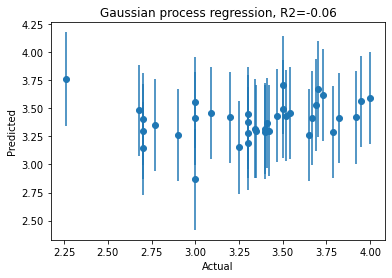

In [16]:
plt.figure()
plt.errorbar(y_test, y_pred_te, yerr=y_pred_te_std, fmt='o')
# r2_score: R^2 (coefficient of determination) regression score function.
plt.title('Gaussian process regression, R2=%.2f' % r2_score(y_test, y_pred_te))
plt.xlabel('Actual')
plt.ylabel('Predicted')

In [17]:
mean_squared_error(y_train, y_pred_tr)

0.1344756624915396

In [18]:
mean_squared_error(y_test, y_pred_te)

0.1700659679906

In [19]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=y_test, name="y_test", line_shape='linear'))
fig.add_trace(go.Scatter(y=y_pred_te, name="y_pred_te", line_shape='linear'))
fig.show()

In [20]:
idx   = np.argsort(y_test)
y_pred_te = y_pred_te.reshape(38,)
list1a = np.array(y_test)[idx]
list2a = np.array(y_pred_te)[idx]
fig = go.Figure()
fig.add_trace(go.Scatter(y=list1a, name="y_test", line_shape='linear'))
fig.add_trace(go.Scatter(y=list2a, name="y_pred_te", line_shape='linear'))
fig.update_layout(title_text='GAUSSIAN REGRESSION MODEL RESULTS SORTED', title_x=0.5)
fig.show()

In [8]:
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train_index, test_index in kfold.split(X):
  #####
  # RBF: Radial-basis function kernel (aka squared-exponential kernel)
  #      Length Scale ; A vector with the same number of dimensions as the inputs X (anisotropic variant of the kernel) 
  # WhiteKernel: Adds noise to the Kernel
  # ConstantKernel: Adding a constant kernel is equivalent to adding a constant.

  kernel = ConstantKernel(1.0) + ConstantKernel(1.0) * RBF(length_scale = 41)  + WhiteKernel(5)

  # kernel2 = ConstantKernel(1.0) + ConstantKernel(1.0) * 1.0 * Matern(length_scale=1.0, nu=1.5) + WhiteKernel(5)
  # The parameter nu controlling the smoothness of the learned function. 
  # The smaller nu, the less smooth the approximated function is.For nu=inf, the kernel becomes equivalent to the RBF kernel 
  # and for nu=0.5 to the absolute exponential kernel. Important intermediate values are nu=1.5 (once differentiable functions) 
  # and nu=2.5 (twice differentiable functions). Note that values of nu not in [0.5, 1.5, 2.5, inf] incur a considerably higher computational cost 
  # (appr. 10 times higher) since they require to evaluate the modified Bessel function. 
  # Furthermore, in contrast to l, nu is kept fixed to its initial value and not optimized.

  #

  # n_restarts_optimizer: The number of restarts of the optimizer for finding the kernel's parameters which maximize the log-marginal likelihood.
  model2 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=1)
  
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  
  # Fit data to model
  history2 = model2.fit(X.iloc[train_index], y.iloc[train_index])
  y_pred_tr, y_pred_tr_std = model2.predict(X.iloc[train_index], return_std=True)
  y_pred_te, y_pred_te_std = model2.predict(X.iloc[test_index], return_std=True)

  #####

  # Generate generalization metrics - model.score(X_test_Input, y_test)
  scores1 = model2.score(X.iloc[test_index], y.iloc[test_index])
  #print(f'Score for fold {fold_no}: {model1.metrics_names[0]} of {scores[0]}; {model1.metrics_names[1]} of {scores[1]*100}%')
  scores2 = mean_squared_error(y.iloc[test_index], y_pred_te)

  print(f'Score for fold {fold_no}: coefficient of determination of the prediction is {scores1}')
  print(f'Score for fold {fold_no}: MSE is {scores2}')

  #acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores2)

  # Increase fold number
  fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('MSE per fold')
for i in range(0, len(loss_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - MSE: {loss_per_fold[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> MSE: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: coefficient of determination of the prediction is -0.01391622522239011
Score for fold 1: MSE is 0.10288132104262117
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: coefficient of determination of the prediction is 0.019354405124368035
Score for fold 2: MSE is 0.12434423154835501
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: coefficient of determination of the prediction is 0.042358149805062584
Score for fold 3: MSE is 0.22370778895304486
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: coefficient of determination of the prediction is 0.1214309176908609
Score for fold 4: MSE is 0.12492570911812562
------------------------------------------------------------------------
Train

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


Score for fold 7: coefficient of determination of the prediction is -0.09827287559516273
Score for fold 7: MSE is 0.1563052221164205
------------------------------------------------------------------------
Training for fold 8 ...
Score for fold 8: coefficient of determination of the prediction is -0.08225885102679498
Score for fold 8: MSE is 0.2637411375070766
------------------------------------------------------------------------
Training for fold 9 ...
Score for fold 9: coefficient of determination of the prediction is -0.037579440044370305
Score for fold 9: MSE is 0.20337998107425273
------------------------------------------------------------------------
Training for fold 10 ...
Score for fold 10: coefficient of determination of the prediction is -0.1192450698975771
Score for fold 10: MSE is 0.1110640009807716
------------------------------------------------------------------------
MSE per fold
------------------------------------------------------------------------
> Fold 1 - MSE

In [21]:
y_pred_te = model2.predict(X.iloc[test_index])
y_test = y.iloc[test_index]

In [23]:
idx   = np.argsort(y_test)
y_pred_te = y_pred_te.reshape(y_pred_te.shape[0],)
list1 = np.array(y_test)[idx]
list2 = np.array(y_pred_te)[idx]
fig = go.Figure()
fig.add_trace(go.Scatter(y=list1, name="y_test", line_shape='linear'))
fig.add_trace(go.Scatter(y=list2, name="y_predict_dnn", line_shape='linear'))
fig.update_layout(title_text='GAUSSIAN REGRESSION MODEL RESULTS SORTED', title_x=0.5)
fig.show()